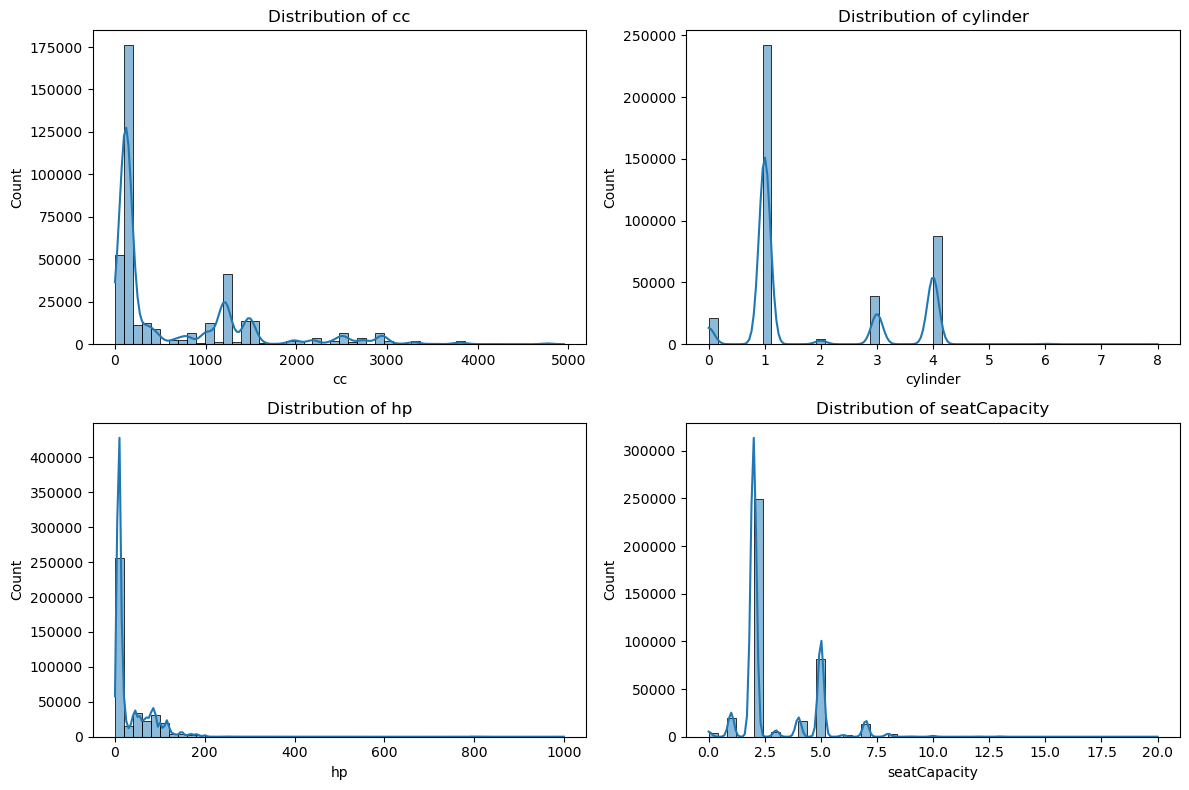

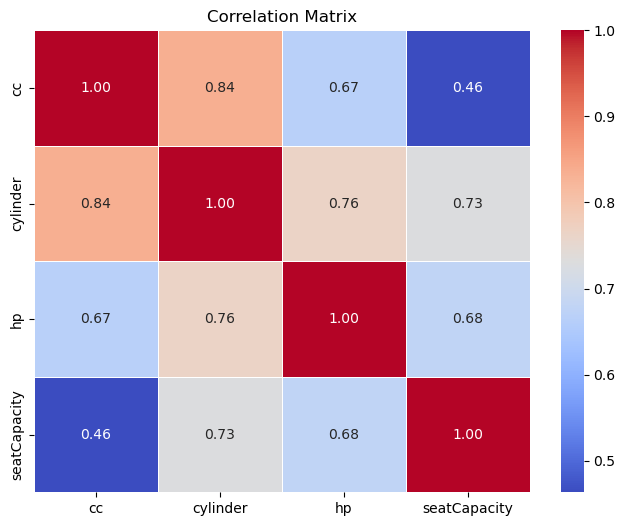

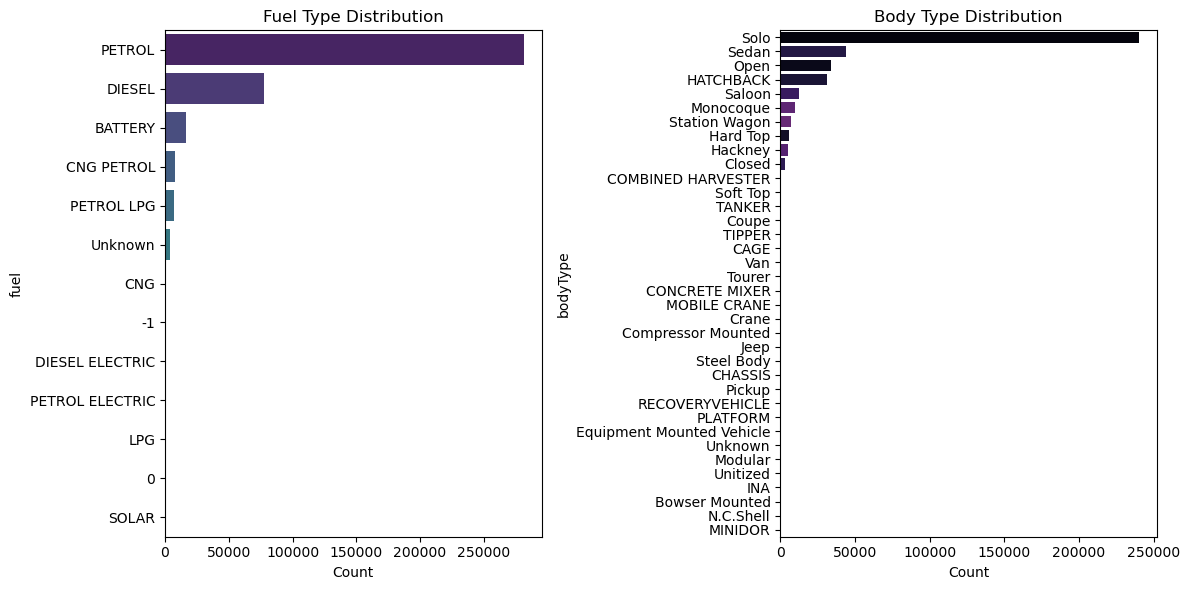

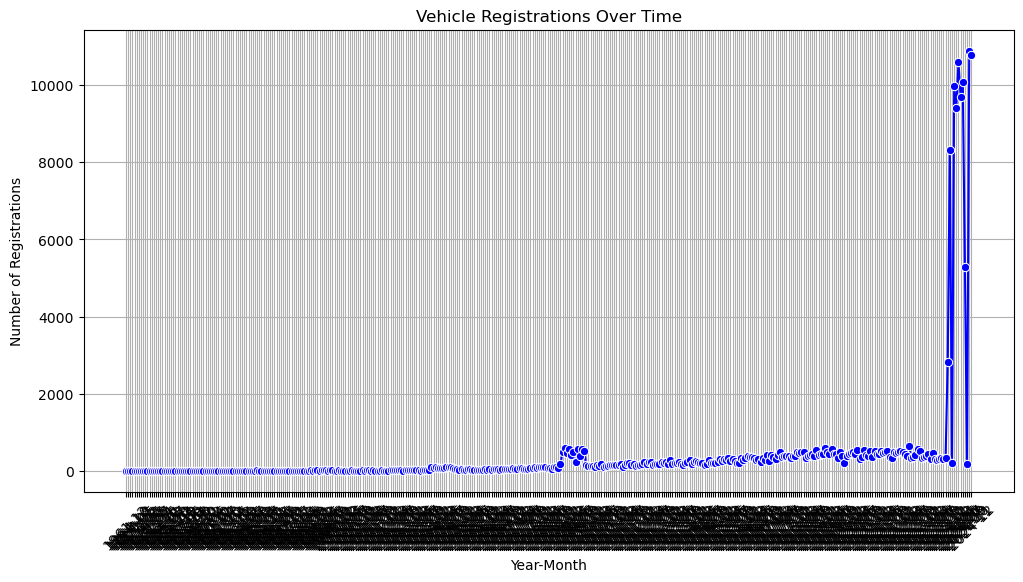

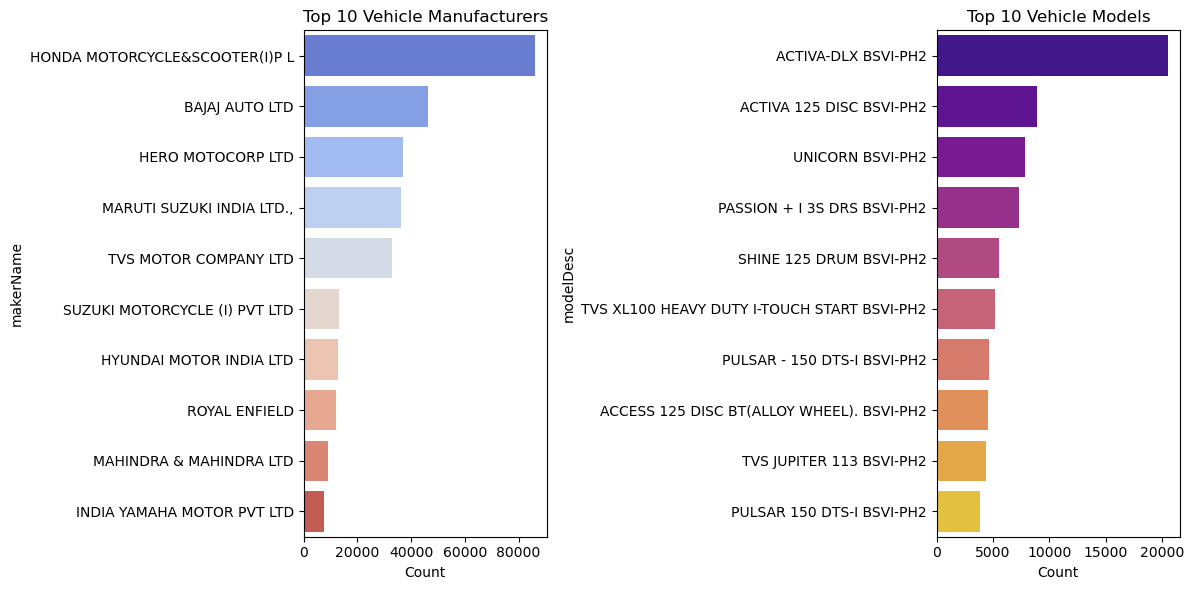

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
# file_path = "/mnt/data/ts_transport_registration_01_11_2024to30_11_2024.csv"
df = pd.read_csv("DATASET.csv")

# Convert date columns to datetime format
date_columns = ["regvalidfrom", "regvalidto", "fromdate", "todate"]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Handle missing values
df = df.assign(
    registrationNo=df['registrationNo'].fillna('Unknown'),
    regvalidfrom=df['regvalidfrom'].fillna(pd.NaT),
    fuel=df['fuel'].fillna('Unknown'),
    bodyType=df['bodyType'].fillna('Unknown')
)


# Outlier Removal
cc_threshold = 5000
cylinder_threshold = 12
hp_threshold = 1000
seat_capacity_threshold = 20
df_filtered = df[(df['cc'] <= cc_threshold) & (df['cylinder'] <= cylinder_threshold) &
                 (df['hp'] <= hp_threshold) & (df['seatCapacity'] <= seat_capacity_threshold)]

# Visualizing Distributions
plt.figure(figsize=(12, 8))
numeric_columns = ['cc', 'cylinder', 'hp', 'seatCapacity']
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_filtered[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_filtered[numeric_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Categorical Data Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(y=df_filtered["fuel"], order=df_filtered["fuel"].value_counts().index, hue=df_filtered["fuel"], palette="viridis", legend=False)
plt.title("Fuel Type Distribution")
plt.xlabel("Count")
plt.subplot(1, 2, 2)
sns.countplot(y=df_filtered["bodyType"], order=df_filtered["bodyType"].value_counts().index, hue=df_filtered["bodyType"], palette="magma", legend=False)
plt.title("Body Type Distribution")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# Registration Trends
df_filtered = df_filtered.copy()  # Ensure modifications are safe
df_filtered.loc[:, 'reg_year_month'] = df_filtered['regvalidfrom'].dt.to_period('M')
monthly_registrations = df_filtered['reg_year_month'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_registrations.index.astype(str), y=monthly_registrations.values, marker="o", color="b")
plt.xticks(rotation=45)
plt.xlabel("Year-Month")
plt.ylabel("Number of Registrations")
plt.title("Vehicle Registrations Over Time")
plt.grid(True)
plt.show()

# Top Manufacturers and Models
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=df_filtered['makerName'].value_counts().head(10).values,
            y=df_filtered['makerName'].value_counts().head(10).index,
            hue=df_filtered['makerName'].value_counts().head(10).index,
            palette="coolwarm", legend=False)
plt.title("Top 10 Vehicle Manufacturers")
plt.xlabel("Count")
plt.subplot(1, 2, 2)
sns.barplot(x=df_filtered['modelDesc'].value_counts().head(10).values,
            y=df_filtered['modelDesc'].value_counts().head(10).index,
            hue=df_filtered['modelDesc'].value_counts().head(10).index,
            palette="plasma", legend=False)
plt.title("Top 10 Vehicle Models")
plt.xlabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
import streamlit as st
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# Load dataset
@st.cache_data
def load_data():
    # file_path = "ts_transport_registration_01_11_2024to30_11_2024.csv"
    df = pd.read_csv("DATASET.csv")
    df['regvalidfrom'] = pd.to_datetime(df['regvalidfrom'], errors='coerce')
    return df

df = load_data()

# Title
st.title("Vehicle Registration Analytics Dashboard")

# Sidebar Filters
st.sidebar.header("Filters")
fuel_filter = st.sidebar.multiselect("Select Fuel Type", df['fuel'].unique(), default=df['fuel'].unique())

# Filter data
df_filtered = df[df['fuel'].isin(fuel_filter)]

# Vehicles Registered by Location
st.subheader("Number of Vehicles Registered by Location")
location_counts = df_filtered['OfficeCd'].value_counts().reset_index()
location_counts.columns = ['Location', 'Count']
fig_location = px.bar(location_counts, x='Location', y='Count', title="Registrations by Location")
st.plotly_chart(fig_location)

# Fuel Type Distribution
st.subheader("Fuel Type Distribution")
fuel_counts = df_filtered['fuel'].value_counts().reset_index()
fuel_counts.columns = ['Fuel Type', 'Count']
fig_fuel = px.pie(fuel_counts, names='Fuel Type', values='Count', title="Fuel Type Distribution")
st.plotly_chart(fig_fuel)

# EV Vehicle Count
st.subheader("Number of EV Vehicles Registered")
ev_count = df_filtered[df_filtered['fuel'].str.contains("Electric", case=False, na=False)].shape[0]
st.metric(label="Total EV Registrations", value=ev_count)

# Machine Learning Models
st.subheader("Predict Insurance Validity & Fuel Type")

# Encode categorical features
label_encoder = LabelEncoder()
df['fuel_encoded'] = label_encoder.fit_transform(df['fuel'])

# Prepare dataset for ML
features = ['cc', 'hp', 'seatCapacity', 'cylinder']
X = df[features].fillna(0)

# Linear Regression for Insurance Prediction
y_insurance = df['todate'].fillna(pd.Timestamp("2025-12-31"))  # Fill missing dates
y_insurance = pd.to_datetime(y_insurance, format="%d/%m/%Y")  # Convert to datetime
y_insurance = y_insurance.astype("int64") // 10**9  # Convert to Unix timestamp (seconds)
X_train, X_test, y_train, y_test = train_test_split(X, y_insurance, test_size=0.2, random_state=42)
insurance_model = LinearRegression()
insurance_model.fit(X_train, y_train)

# Random Forest for Fuel Type Prediction
y_fuel = df['fuel_encoded']
X_train_fuel, X_test_fuel, y_train_fuel, y_test_fuel = train_test_split(X, y_fuel, test_size=0.2, random_state=42)
fuel_model = RandomForestClassifier()
fuel_model.fit(X_train_fuel, y_train_fuel)

# User Input for Predictions
st.sidebar.subheader("Enter Vehicle Details")
cc_input = st.sidebar.number_input("Engine Capacity (cc)", min_value=500, max_value=5000, value=1500)
hp_input = st.sidebar.number_input("Horsepower (hp)", min_value=10, max_value=1000, value=100)
seat_input = st.sidebar.number_input("Seat Capacity", min_value=1, max_value=20, value=5)
cylinder_input = st.sidebar.number_input("Cylinders", min_value=1, max_value=12, value=4)

# Make Predictions
if st.sidebar.button("Predict"):
    user_input = pd.DataFrame([[cc_input, hp_input, seat_input, cylinder_input]], columns=features)
    predicted_insurance = insurance_model.predict(user_input)[0]
    predicted_fuel = fuel_model.predict(user_input)[0]
    fuel_type = label_encoder.inverse_transform([predicted_fuel])[0]
    
    st.subheader("Predictions")
    st.write(f"Predicted Insurance Validity: {pd.to_datetime(predicted_insurance).date()}")
    st.write(f"Predicted Fuel Type: {fuel_type}")

st.write("Data last updated from: ", df['regvalidfrom'].max())


2025-03-07 19:11:34.983 No runtime found, using MemoryCacheStorageManager
2025-03-07 19:11:50.571 Session state does not function when running a script without `streamlit run`
